# Real-Estate Property Recommendation Tool

In [2]:
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
path = "../../../data/estates/*.csv" 

csv_files = glob.glob(path)

# Read the first file with header
df_list = []
df_first = pd.read_csv(csv_files[0])  # Read with header
df_list.append(df_first)

# Read the remaining files without headers, using the first file's columns
for file in csv_files[1:]:
    df = pd.read_csv(file, header=None, names=df_first.columns)
    df_list.append(df)

# Concatenate all DataFrames
final_df = pd.concat(df_list, ignore_index=True)

# Display result
final_df.head(2)

,Brand New Premium 3 Bedroom in Lekki Phase 1,"₦ 150,000 per day","Lekki, Lekki Phase 1",500,3,Unfurnished,3.1,Brand New Premium 3 bedroom in Lekki phase 1\nAvailable from: today \nFeatures:\nPS5\nSwimming pool\n24/7...,38768242,active
0,New Two Bedroom in Jahi Abuja,"₦ 130,000 per day","Abuja (FCT), Jahi",500,2,Unfurnished,2,Refundable Caution Fee applies,41023971,active
1,"3 Bedroom Terrace in Naf Valley Estate, Asokor...","₦ 115,000,000","Abuja (FCT), Asokoro",500,2,Unfurnished,2,3 bedroom Terrace duplex for sale at NAF Valle...,28913134,active


In [4]:
final_df.columns = ['title', 'price', 'location', 'sqm', 'bedrooms', 'furnishing', 'bathrooms', 'description', 'id', 'status']
final_df.shape

(23549, 10)

In [6]:
final_df['missing_description'] = np.where(final_df['description'].isna(),1,0)
final_df['missing_title'] = np.where(final_df['title'].isna(),1,0)
final_df['missing_location'] = np.where(final_df['location'].isna(),1,0)

In [10]:
import re

def extract_amount(value):
 
    value = re.sub(r"[₦,]", "", value)
    
    amount = re.search(r"\d+", value)  
    
    return int(amount.group()) if amount else None

converted_salaries = [extract_amount(s) for s in final_df['price']]
final_df['current_prices'] = converted_salaries

In [12]:
# Function to clean location
def clean_location(value):
    value = str(value)
    value = value.replace("...", "").strip()
    match = re.match(r"(.+?)\s*\((.*?)\),?\s*(.+)", value)
    if match:
        return f"{match.group(3)}, {match.group(1)}"
    return value

# Function to clean furnishing
def clean_furnishing(value):
    valid_furnishings = {"Furnished", "Unfurnished", "Semi-Furnished"}
    return value if value in valid_furnishings else "Unknown"  # Replace invalid values

# Apply cleaning functions
final_df["location"] = final_df["location"].apply(clean_location)
final_df["title"] = final_df["title"].apply(clean_location)
final_df["description"] = final_df["description"].apply(clean_location)

In [14]:
#Reomve messy data like text in string columns
final_df["sqm"] = pd.to_numeric(final_df["sqm"], errors="coerce")
final_df["current_prices"] = pd.to_numeric(final_df["current_prices"], errors="coerce")
final_df.dropna(subset=["sqm", "current_prices"], inplace=True)
final_df["sqm"] = final_df["sqm"].replace({'': None}).astype(float).fillna(0).astype(int)

In [16]:
def convert_bedrooms_bathrooms(value):
    if isinstance(value, str) and "more than" in value:
        number = int(value.split()[-1])
        return number + 1 
    return int(value) 

# Apply the function
final_df["bedrooms"] = final_df["bedrooms"].apply(convert_bedrooms_bathrooms)
final_df["bathrooms"] = final_df["bathrooms"].apply(convert_bedrooms_bathrooms)

In [18]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23548 entries, 0 to 23548
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   title                23548 non-null  object 
 1   price                23548 non-null  object 
 2   location             23548 non-null  object 
 3   sqm                  23548 non-null  int64  
 4   bedrooms             23548 non-null  int64  
 5   furnishing           23548 non-null  object 
 6   bathrooms            23548 non-null  int64  
 7   description          23548 non-null  object 
 8   id                   23548 non-null  object 
 9   status               23548 non-null  object 
 10  missing_description  23548 non-null  int64  
 11  missing_title        23548 non-null  int64  
 12  missing_location     23548 non-null  int64  
 13  current_prices       23548 non-null  float64
dtypes: float64(1), int64(6), object(7)
memory usage: 2.7+ MB


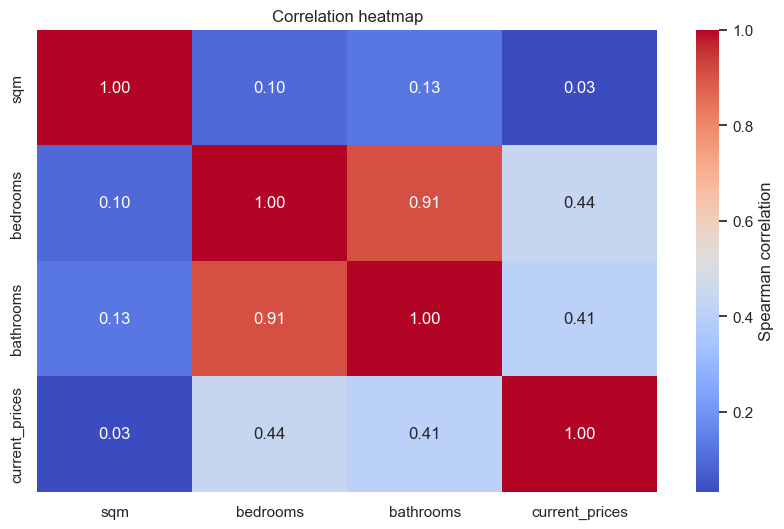

In [20]:
column_of_interest = ['sqm', 'bedrooms', 'bathrooms', 'current_prices']

correlation_matrix = final_df[column_of_interest].corr(method = 'spearman')

sns.set_theme(style='white')
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={"label": "Spearman correlation"})
heatmap.set_title('Correlation heatmap')
plt.show()

In [40]:
def clean_text(value):
    # Convert to string in case input is not a string
    value = str(value)

    # Remove newline characters and "..."
    value = value.replace("\n", " ").replace("...", "")

    # Remove all non-alphanumeric characters (keep only letters and numbers)
    value = re.sub(r"[^a-zA-Z0-9\s]", "", value)

    # Remove extra spaces
    return " ".join(value.split())

final_df["description"] = final_df["description"].apply(clean_text)


In [42]:
final_df['words_in_description'] = final_df['description'].str.split().str.len()

In [44]:
final_df.loc[final_df['words_in_description'].between(1,4), 'description']

0        Refundable Caution Fee applies
12                 2 bedroom jahi abuja
340                2 bedroom jahi abuja
472                Banana island Luxury
604                Sophisticated enough
                      ...              
22645              3 bedroom smart home
22942          Wuye 3 bedroom apartment
23322                       TO LETLEASE
23426          Wuye 3 bedroom apartment
23522      Behind Lagos Business School
Name: description, Length: 164, dtype: object

In [48]:
final_df.loc[final_df['words_in_description'].between(5,24), 'description']

1        3 bedroom Terrace duplex for sale at NAF Valle...
2                     One bedroom bedroom apartment to let
3        pretty decent 4 bed semidetached duplex with b...
4        To let Spacious room upstairs in a shared apar...
5                   Affordable Studio apartment at Asokoro
                               ...                        
23544    A decent 3 bedroom flat with 2 toilet and 2 ba...
23545    Well maintained 4bedroom semi detach duplex to...
23546    It is in a environment suitable for mixed deve...
23547    Asokoro extension hills by sir pauls propertie...
23548    This land is more than 10plots its located at ...
Name: description, Length: 23380, dtype: object

In [52]:
final_df['description_title_location'] = (
    np.where(
        final_df['description'].isna(), final_df['title'],
        final_df[['description', 'title', 'location']].astype(str).agg(": ".join, axis=1)
    )
)

In [74]:
final_df['tagged_description'] = final_df[['id','description_title_location']].astype(str).agg(" ".join, axis=1)

In [76]:
(final_df.drop(['missing_description', 'missing_title', 'missing_location', 'words_in_description'], axis=1).to_csv('house_cleaned.csv', index=False))